Starting Strategy Comparison Script...
(3019, 93)
Loaded price relative vectors CSV in 0.0448 seconds.
Initialized portfolio in 0.0001 seconds.

Running strategy: Buy and Hold
    Final wealth = 9.1742, Exponential growth = 0.0007, Sharpe = 0.5797
    Strategy 'Buy and Hold' completed in 0.0160 seconds.

Running strategy: Best Stock
    Final wealth = 0.0153, Exponential growth = -0.0014, Sharpe = 0.0905
    Strategy 'Best Stock' completed in 0.0082 seconds.

Running strategy: Constant Rebalancing
    Final wealth = 12.1584, Exponential growth = 0.0008, Sharpe = 0.7553
    Strategy 'Constant Rebalancing' completed in 0.0072 seconds.

Running strategy: Histogram-Based Selection + Log-Optimal Portfolio
    Final wealth = 598.7398, Exponential growth = 0.0021, Sharpe = 1.1492
    Strategy 'Histogram-Based Selection + Log-Optimal Portfolio' completed in 512.0490 seconds.

Running strategy: Histogram-Based Selection + Semi-Log-Optimal Portfolio
    Final wealth = 610.4945, Exponential growt

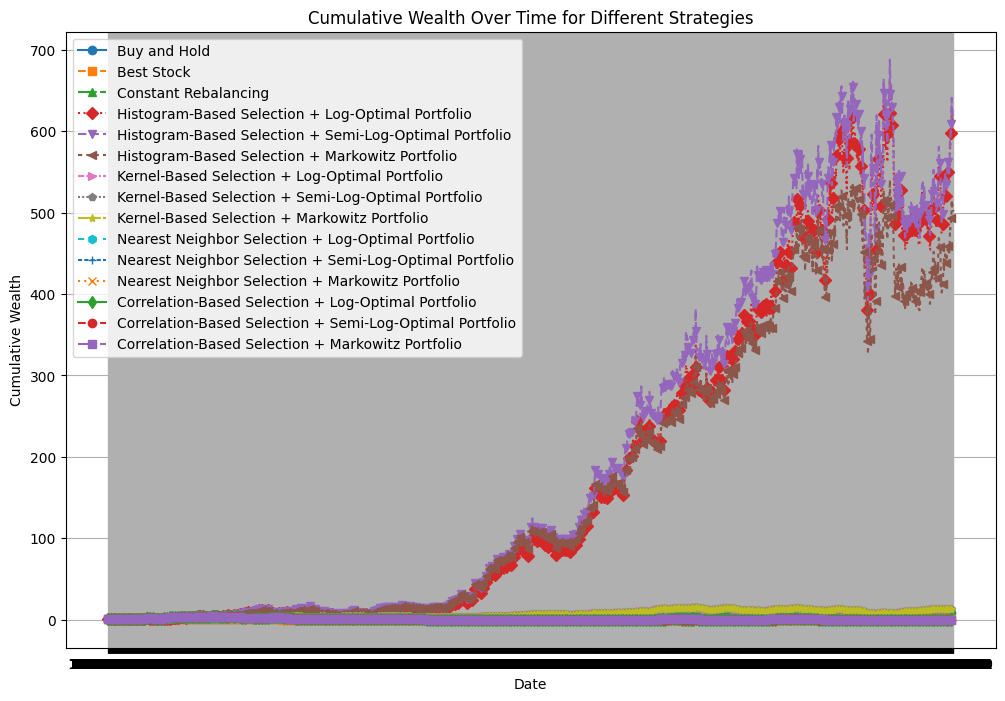

Plot generated in 8.0279 seconds.

===== Final Sharpe Ratios (Sorted) =====
Histogram-Based Selection + Markowitz Portfolio: 1.1642
Histogram-Based Selection + Semi-Log-Optimal Portfolio: 1.1584
Histogram-Based Selection + Log-Optimal Portfolio: 1.1492
Constant Rebalancing: 0.7553
Kernel-Based Selection + Semi-Log-Optimal Portfolio: 0.7510
Kernel-Based Selection + Log-Optimal Portfolio: 0.7510
Kernel-Based Selection + Markowitz Portfolio: 0.7510
Buy and Hold: 0.5797
Nearest Neighbor Selection + Markowitz Portfolio: 0.4064
Nearest Neighbor Selection + Semi-Log-Optimal Portfolio: 0.4053
Nearest Neighbor Selection + Log-Optimal Portfolio: 0.3948
Correlation-Based Selection + Markowitz Portfolio: 0.1211
Correlation-Based Selection + Semi-Log-Optimal Portfolio: 0.0954
Correlation-Based Selection + Log-Optimal Portfolio: 0.0914
Best Stock: 0.0905

Total execution time: 2853.0074 seconds.


In [1]:
# ---------------------------------
# Pattern Matching Strategy Comparison
# ---------------------------------

import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

# Utility Function Imports (only import those needed)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utilities import (initialize_portfolio, calculate_cumulative_wealth_over_time, 
                       calculate_exponential_growth_rate, compute_periodic_returns, 
                       compute_sharpe_ratio)

# Algorithm Imports
from Strategies.benchmarks import *
from Strategies.pattern_matching import *

# Start total timer
total_start = time.time()
print("Starting Strategy Comparison Script...")

# --------------------------
# Data Loading & Initialization
# --------------------------
start_csv = time.time()
price_relative_df = pd.read_csv("..\\..\\Data\\Price Relative Vectors\\price_relative_vectors.csv", index_col=0)
print(price_relative_df.shape)
end_csv = time.time()
print(f"Loaded price relative vectors CSV in {end_csv - start_csv:.4f} seconds.")

start_portfolio = time.time()
b = initialize_portfolio(price_relative_df.shape[1])
end_portfolio = time.time()
print(f"Initialized portfolio in {end_portfolio - start_portfolio:.4f} seconds.")

# Build price relative vectors and dates
price_relative_vectors_array = price_relative_df.values
dates = price_relative_df.index

# --------------------------
# Strategy Definitions
# --------------------------
strategies = {
    'Buy and Hold': buy_and_hold,
    'Best Stock': best_stock,
    'Constant Rebalancing': constant_rebalancing
}

# Build pattern-matching strategy combos
sample_selection_methods = {
    'Histogram-Based Selection': histogram_based_selection,
    'Kernel-Based Selection': kernel_based_selection,
    'Nearest Neighbor Selection': nearest_neighbor_selection,
    'Correlation-Based Selection': correlation_based_selection
}
portfolio_optimization_methods = {
    'Log-Optimal Portfolio': log_optimal_portfolio,
    'Semi-Log-Optimal Portfolio': semi_log_optimal_portfolio,
    'Markowitz Portfolio': markowitz_portfolio
}
combos = []
for ss_name, ss_func in sample_selection_methods.items():
    for po_name, po_func in portfolio_optimization_methods.items():
        combination_name = f"{ss_name} + {po_name}"
        combos.append((combination_name, ss_func, po_func))

# Add each pattern-matching combo to the strategies dictionary
for combination_name, ss_func, po_func in combos:
    def make_pattern_matching_strategy(ss=ss_func, po=po_func):
        def strategy(b, price_rels):
            methods = {'sample_selection': ss, 'portfolio_optimization': po}
            return pattern_matching_portfolio_master(b, price_rels, methods)
        return strategy
    strategies[combination_name] = make_pattern_matching_strategy()


# Pre-allocate dictionaries for results
cumulative_wealth_dict = {}
sharpe_dict = {}

# Setup plotting style options
line_styles = ['-', '--', '-.', ':',
               (0, (4, 2)), (0, (2, 2)), (0, (3, 1, 1, 1)), (0, (1, 1)),
               (0, (5, 1)), (0, (3, 3)), (0, (2, 1)), (0, (1, 2, 1, 2))]
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', '+', 'x', 'd']

num_strategies = len(strategies)
if len(line_styles) < num_strategies:
    line_styles *= (num_strategies // len(line_styles) + 1)
if len(markers) < num_strategies:
    markers *= (num_strategies // len(markers) + 1)

plt.figure(figsize=(12, 8))

# --------------------------
# Run Strategies
# --------------------------
strategies_start = time.time()
for i, (strategy_name, strategy_function) in enumerate(strategies.items()):
    print(f"\nRunning strategy: {strategy_name}")
    strat_start = time.time()
    try:
        # 1) Compute portfolio weight vectors for each period
        b_n_strat = strategy_function(b, price_relative_vectors_array)
        
        # 2) Compute cumulative wealth over time
        # (Note: if possible, you can modify calculate_cumulative_wealth_over_time 
        #  to use vectorized operations – see note below.)
        cum_wealth = calculate_cumulative_wealth_over_time(b_n_strat, price_relative_vectors_array)
        cumulative_wealth_dict[strategy_name] = cum_wealth

        # 3) Calculate exponential growth rate
        final_wealth = cum_wealth[-1]
        n_periods = len(price_relative_vectors_array)
        exp_growth = calculate_exponential_growth_rate(final_wealth, n_periods)

        # 4) Calculate daily returns and Sharpe ratio
        daily_returns = compute_periodic_returns(cum_wealth)
        sr = compute_sharpe_ratio(daily_returns, freq=252, risk_free_rate=0.05)
        sharpe_dict[strategy_name] = sr

        strat_end = time.time()
        print(f"    Final wealth = {final_wealth:.4f}, Exponential growth = {exp_growth:.4f}, Sharpe = {sr:.4f}")
        print(f"    Strategy '{strategy_name}' completed in {strat_end - strat_start:.4f} seconds.")
    except Exception as e:
        print(f"Error in strategy '{strategy_name}': {e}")
        continue
strategies_end = time.time()
print(f"\nAll strategies completed in {strategies_end - strategies_start:.4f} seconds.")

# --------------------------
# Plot Results
# --------------------------
plot_start = time.time()
for i, (strategy_name, cum_wealth) in enumerate(cumulative_wealth_dict.items()):
    plt.plot(
        dates, cum_wealth,
        label=strategy_name,
        linestyle=line_styles[i],
        marker=markers[i],
        markevery=10,
        markersize=6,
        linewidth=1.5
    )

plt.title('Cumulative Wealth Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend()
plt.grid(True)
plt.show()
plot_end = time.time()
print(f"Plot generated in {plot_end - plot_start:.4f} seconds.")

# --------------------------
# Final Results: Sharpe Ratios
# --------------------------
print("\n===== Final Sharpe Ratios (Sorted) =====")
sorted_sharpe = sorted(sharpe_dict.items(), key=lambda x: x[1], reverse=True)
for strat_name, sr_val in sorted_sharpe:
    print(f"{strat_name}: {sr_val:.4f}")

total_end = time.time()
print(f"\nTotal execution time: {total_end - total_start:.4f} seconds.")
